In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score ,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from collections import Counter
import matplotlib.pyplot as plt
from datetime import date
from matplotlib import style
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
plt.style.use('ggplot')
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

In [29]:
def label_setter(df):
    print(df)
    if abs(df['High']-df['Price'])<abs(df['Price']-df['Low']):
        return 1
    else :
        return 0

In [62]:
def source():
    crude_data=pd.read_csv('crude.csv',thousands=',')
    inven_data=pd.read_csv('inventory_crude.csv',index_col=0)
    crude_data.drop(columns={'Vol.','Change %'},inplace=True)
    crude_data.Date = pd.to_datetime(crude_data.Date)
    inven_data.Date=pd.to_datetime(inven_data.Date)
    inven_data=inven_data.iloc[::-1]
    #inven_data.set_index('Date',inplace=True)
    inven_data.dropna(inplace=True)
    crude_data=crude_data[::-1]
    crude_data.set_index('Date',inplace=True)
    inven_data.set_index('Date',inplace=True)
    return crude_data,inven_data


In [31]:
def forward_return(df,days):
    for i in range(1,days+1):
        df['return_{}d'.format(i)]=100*(df['Price'].shift(i)-df['Price'])/df['Price']
    return df

In [74]:
def buy_sell_hold(*args):
    cols=[c for c in args]
    #print(cols)
    requirement=1
    for col in cols:
        if col>requirement:
            return 1
#         if col<-requirement:
#             return -1
    else :
        return 0


In [75]:
def mapper(df):
    ticker='return'
    days=3
    df['{}_target'.format(ticker)]=list(map(buy_sell_hold, *[df['{}_{}d'.format(ticker, i)]for i in range(1, days+1)]))
    return df

In [71]:
def preprocessed_data():
    crude,inventory=source()
    crude=forward_return(crude,3).dropna()
    crude=mapper(crude)
    final_df=pd.merge(crude,inventory,how='inner',left_index=True,right_index=True)
    return final_df

In [79]:
def do_ml():
    df=preprocessed_data()
    X=df[['Actual','forcast']].values
    y=df['return_target'].values
    train_X,test_X,train_y,test_y=train_test_split(X,y,test_size= 0.25,random_state=0)
    #clf=KNeighborsClassifier()
    clf=VotingClassifier([('lsvc',svm.LinearSVC()),('knn',KNeighborsClassifier()),('rfor',RandomForestClassifier())])
    clf.fit(train_X,train_y)
    confidence=clf.score(test_X,test_y)
    accuracies=cross_val_score(estimator=clf,X=test_X,y=test_y,cv=10)
    print('Cross Acc mean:',accuracies.mean())
    print('Acc:',confidence)
    prediction=clf.predict(test_X)
    print('Predic spread:',Counter(prediction))
    #plotting
    X_set, y_set = train_X, train_y
    X1, X2 = np.meshgrid(np.arange( X_set[:, 0].min() -1,X_set[:, 0].max()+1,  0.01),
                         np.arange( X_set[:, 1].min()-1 ,  X_set[:, 1].max()+1,   0.01))
    plt.contourf(X1, X2, clf.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.1, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green'))(i),label=j)
        #print(X_set[y_set ==j,0])

    plt.title(' Prediction')
    plt.xlabel('Actual')
    plt.ylabel('predicted')
    plt.legend()
    plt.show()
    
    return 0 #confidence
    
    
    #return confidence
    

Cross Acc mean: 0.6058585858585859
Acc: 0.6063829787234043
Predic spread: Counter({0: 52, 1: 42})


<IPython.core.display.Javascript object>


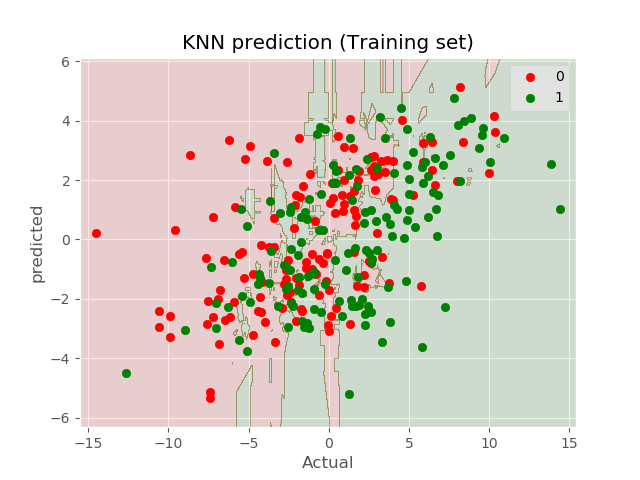

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0

In [78]:
do_ml()